<a href="https://colab.research.google.com/github/beercafeguy/PyMLLab/blob/master/practice/Insurence_data_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = 'https://raw.githubusercontent.com/beercafeguy/PyMLLab/master/data/insurance.csv'

In [5]:
import urllib

urllib.request.urlretrieve(path,'insurance.csv')

('insurance.csv', <http.client.HTTPMessage at 0x7efad2653d60>)

In [6]:
!ls -ltr

total 60
drwxr-xr-x 1 root root  4096 Aug 17 13:29 sample_data
-rw-r--r-- 1 root root 55628 Aug 20 11:53 insurance.csv


In [7]:
df = pd.read_csv('insurance.csv')

In [8]:
df.shape

(1338, 7)

In [9]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [10]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

As we do not have any null values, we need to not to use any imputer here. We will directly move to Data Transformation

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [20]:
target_col = 'charges'
num_cols = list(df.select_dtypes(include='number').columns)
num_cols.remove(target_col)

cat_cols = list(df.select_dtypes(exclude='number').columns)

print(cat_cols)
print(num_cols)

['sex', 'smoker', 'region']
['age', 'bmi', 'children']


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

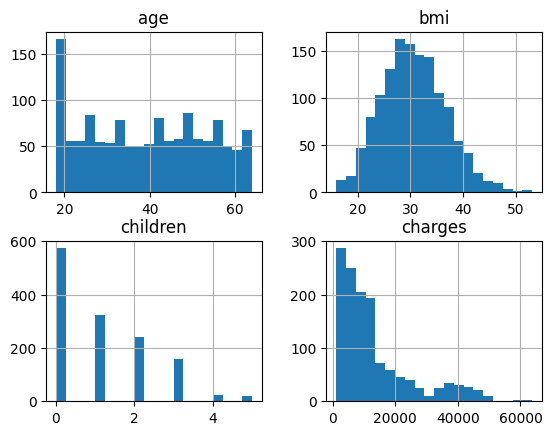

In [23]:
%matplotlib inline
df.hist(bins=20)

### Apply Train test split

In [24]:
from sklearn.model_selection import train_test_split

df_train,df_test = train_test_split(df,test_size=0.2,random_state=2023)

In [25]:
df_train.shape

(1070, 7)

In [26]:
df_test.shape

(268, 7)

### Stratified Sampling

In [33]:
df.region.value_counts()/len(df)

southeast    0.272048
southwest    0.242900
northwest    0.242900
northeast    0.242152
Name: region, dtype: float64

In [32]:
df_train.region.value_counts()/len(df_train)

southeast    0.280374
northeast    0.245794
southwest    0.242991
northwest    0.230841
Name: region, dtype: float64

In a random split, we see that distribution might be different in training data and overall data. To fix this, we can use stratified sampling

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2023)

for train_index, test_index in split.split(df, df["region"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [36]:
strat_train_set.region.value_counts()/len(strat_train_set) # this should be much closer to original distribution

southeast    0.271963
northwest    0.242991
southwest    0.242991
northeast    0.242056
Name: region, dtype: float64

In [37]:
strat_train_set.head()

,age,sex,bmi,children,smoker,region,charges
140,34,male,22.420,2,no,northeast,27375.90478
236,18,female,26.730,0,no,southeast,1615.76670
781,18,male,41.140,0,no,southeast,1146.79660
199,64,female,39.330,0,no,northeast,14901.51670
1299,19,female,25.745,1,no,northwest,2710.82855


In [38]:
strat_test_set.head()

,age,sex,bmi,children,smoker,region,charges
548,25,female,28.595,0,no,northeast,3213.62205
107,26,male,30.875,2,no,northwest,3877.30425
696,53,female,32.300,2,no,northeast,29186.48236
724,50,female,27.075,1,no,northeast,10106.13425
95,28,female,37.620,1,no,southeast,3766.88380


### Compare the difference in random and strat sampling

In [39]:
def get_group_proportion(ip_df):
  return ip_df.region.value_counts()/len(ip_df)

In [43]:
from numpy.core.multiarray import compare_chararrays
compare_proportions = pd.DataFrame(
    {
        'Overall' : get_group_proportion(df),
        'Random' : get_group_proportion(df_train),
        'Strat': get_group_proportion(strat_train_set)
    }
).sort_index()
compare_proportions['Random Error'] = 100 - (compare_proportions['Random'] /compare_proportions['Overall'])*100
compare_proportions['Strat Error'] = 100 - (compare_proportions['Strat'] /compare_proportions['Overall'])*100

compare_proportions

,Overall,Random,Strat,Random Error,Strat Error
northeast,0.242152,0.245794,0.242056,-1.503981,0.039806
northwest,0.242900,0.230841,0.242991,4.964486,-0.037383
southeast,0.272048,0.280374,0.271963,-3.060491,0.031324
southwest,0.242900,0.242991,0.242991,-0.037383,-0.037383


So if you notice here, error rate is very less in Strat sampling so we will use the same for our experimentation

## Corr

<ipython-input-45-88a4de51724e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = strat_train_set.corr()


<Axes: >

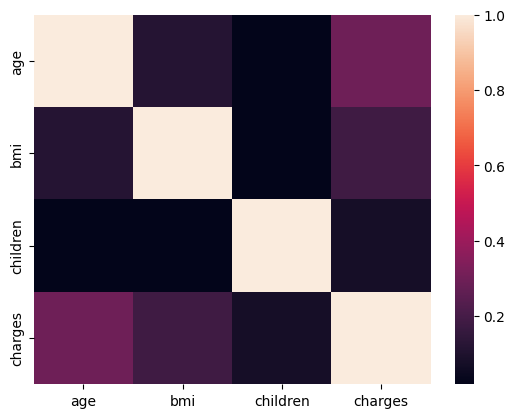

In [45]:
import seaborn as sns

cor = strat_train_set.corr()
sns.heatmap(cor)

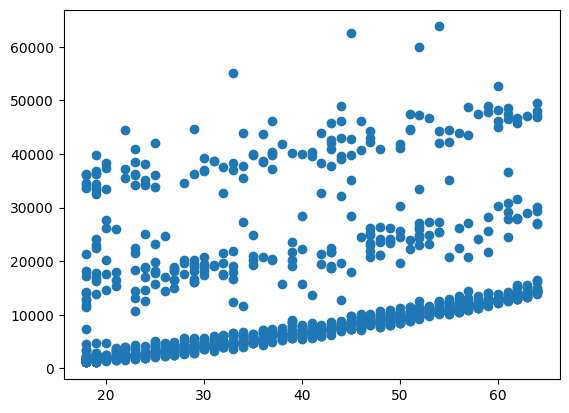

In [46]:
plt.scatter(strat_train_set.age,strat_train_set.charges)

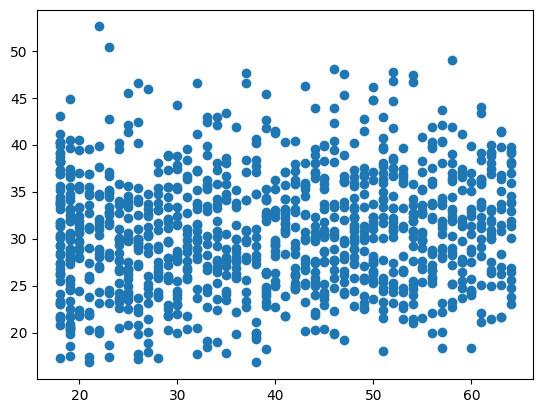

In [47]:
plt.scatter(strat_train_set.age,strat_train_set.bmi)

In [48]:

cor["charges"].sort_values(ascending=False)

charges     1.000000
age         0.295002
bmi         0.181156
children    0.074539
Name: charges, dtype: float64

array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='bmi', ylabel='age'>,
        <Axes: xlabel='children', ylabel='age'>,
        <Axes: xlabel='charges', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='bmi'>,
        <Axes: xlabel='bmi', ylabel='bmi'>,
        <Axes: xlabel='children', ylabel='bmi'>,
        <Axes: xlabel='charges', ylabel='bmi'>],
       [<Axes: xlabel='age', ylabel='children'>,
        <Axes: xlabel='bmi', ylabel='children'>,
        <Axes: xlabel='children', ylabel='children'>,
        <Axes: xlabel='charges', ylabel='children'>],
       [<Axes: xlabel='age', ylabel='charges'>,
        <Axes: xlabel='bmi', ylabel='charges'>,
        <Axes: xlabel='children', ylabel='charges'>,
        <Axes: xlabel='charges', ylabel='charges'>]], dtype=object)

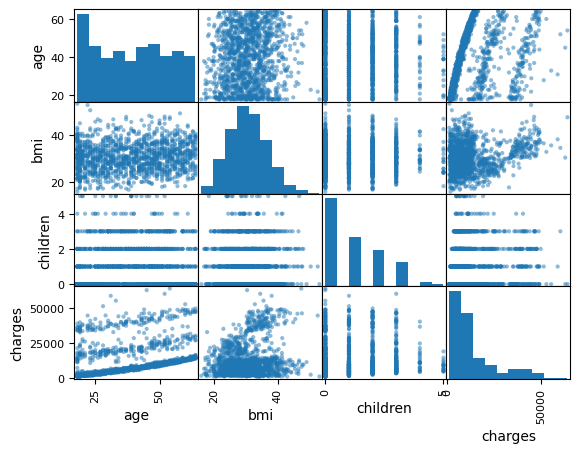

In [50]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[df.select_dtypes(include='number').columns])

Simple Imputer

In [52]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan,strategy='median')
imputer.fit(df[['age']])

SimpleImputer(strategy='median')

In [53]:
imputer.statistics_

array([39.])

In [54]:
df.age.median()

39.0

In [55]:
imputer.strategy

'median'

### Handling Text and Categorical Attributes

In [56]:
strat_train_set.head()

,age,sex,bmi,children,smoker,region,charges
140,34,male,22.420,2,no,northeast,27375.90478
236,18,female,26.730,0,no,southeast,1615.76670
781,18,male,41.140,0,no,southeast,1146.79660
199,64,female,39.330,0,no,northeast,14901.51670
1299,19,female,25.745,1,no,northwest,2710.82855


In [65]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


# apply Label encoder in sex and region column
# apply OHE in region column

le_sex = LabelEncoder()
le_sex.fit_transform(strat_train_set['sex'])

array([1, 0, 1, ..., 0, 0, 0])

In [66]:
le_smoker = LabelEncoder()
le_smoker.fit_transform(strat_train_set['smoker'])

array([0, 0, 0, ..., 0, 0, 0])

In [67]:
# OHE

ohe = OneHotEncoder(sparse_output=False)
ohe.fit_transform([['region']])

array([[1.]])

In [84]:
ct = ColumnTransformer([("encoder", OneHotEncoder(sparse_output=False), cat_cols)],remainder='passthrough')

encoded_df = ct.fit_transform(strat_train_set)

In [78]:
X = encoded_df[:,:-1]
y = encoded_df[:,-1]

In [79]:
y

array([27375.90478,  1615.7667 ,  1146.7966 , ...,  3021.80915,
        2200.83085,  7985.815  ])

### Apply Standard scaler

In [81]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
print(X_scaled[1:5])

[[ 0.99626864 -0.99626864  0.49561523 -0.49561523 -0.56511841 -0.56655772
   1.63614668 -0.56655772 -1.51693607 -0.64460655 -0.91596563]
 [-1.00374533  1.00374533  0.49561523 -0.49561523 -0.56511841 -0.56655772
   1.63614668 -0.56655772 -1.51693607  1.67597282 -0.91596563]
 [ 0.99626864 -0.99626864  0.49561523 -0.49561523  1.76954066 -0.56655772
  -0.61119215 -0.56655772  1.75333651  1.3844913  -0.91596563]
 [ 0.99626864 -0.99626864  0.49561523 -0.49561523 -0.56511841  1.76504522
  -0.61119215 -0.56655772 -1.44584319 -0.80323047 -0.07900301]]


In [82]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_scaled,y)

LinearRegression()

In [85]:
encoded_test = ct.transform(strat_test_set)
X_test = encoded_test[:,:-1]
y_test = encoded_test[:,-1]
X_test_scaled = sc.transform(X_test)

In [87]:
y_pred = lin_reg.predict(X_test_scaled)

In [91]:
from sklearn.metrics import accuracy_score, mean_absolute_error,mean_squared_error,r2_score

print(r2_score(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

0.7629028279136874
6065.285346946404


In [95]:
np.printoptions(precision=0.2)
np.concatenate((y_test.reshape(len(y_test),1),y_pred.reshape(len(y_pred),1)),1)[:10]

array([[ 3213.62205   ,  4686.50605536],
       [ 3877.30425   ,  5506.65181249],
       [29186.48236   , 13658.40568562],
       [10106.13425   , 10902.41572895],
       [ 3766.8838    ,  8077.11199515],
       [ 7222.78625   ,  6598.37485739],
       [17468.9839    , 27211.93810563],
       [ 2632.992     ,  4287.33243726],
       [16232.847     , 24735.0363423 ],
       [ 5584.3057    ,  8332.89766589]])

# Train the same in decision tree regressor

In [96]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(max_depth=10)
dt_reg.fit(X_scaled,y)

DecisionTreeRegressor(max_depth=10)

In [97]:
y_pred = dt_reg.predict(X_test_scaled)

In [98]:
from sklearn.metrics import accuracy_score, mean_absolute_error,mean_squared_error,r2_score

print(r2_score(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

0.7734733507950735
5928.539269469472


In [100]:
print(r2_score(y,dt_reg.predict(X_scaled)))
print(np.sqrt(mean_squared_error(y,dt_reg.predict(X_scaled))))

0.9695994761070269
2094.7434325839595


### Train in random forest

In [102]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=10)
rf_reg.fit(X_scaled,y)


RandomForestRegressor(n_estimators=10)

In [103]:
y_pred = rf_reg.predict(X_test_scaled)

In [104]:
from sklearn.metrics import accuracy_score, mean_absolute_error,mean_squared_error,r2_score

print(r2_score(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

0.850148302368883
4821.907601706278


### Apply KFold cross validation

In [110]:
from sklearn.metrics.cluster import entropy
from sklearn.model_selection import cross_val_score

neg_rmses = cross_val_score(
    rf_reg,
    X_scaled,
    y,
    scoring="neg_mean_squared_error",
    cv = 10
)
scores = np.sqrt(-neg_rmses)

In [112]:
print(f'Mean {scores.mean()}')
print(f'Std Dev {scores.std()}')

Mean 5108.293307622445
Std Dev 613.9454955088887


### Apply CV for hyperparameters

In [117]:
from sklearn.model_selection import GridSearchCV

params = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor(random_state=2023)
grid_search = GridSearchCV(forest_reg, params, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_scaled, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=2023),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [118]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [119]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=2023)

In [120]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

5750.844602977507 {'max_features': 2, 'n_estimators': 3}
5340.532649941293 {'max_features': 2, 'n_estimators': 10}
5096.502726251116 {'max_features': 2, 'n_estimators': 30}
5627.004977373287 {'max_features': 4, 'n_estimators': 3}
5105.608729195623 {'max_features': 4, 'n_estimators': 10}
4892.948730074179 {'max_features': 4, 'n_estimators': 30}
5396.715603012955 {'max_features': 6, 'n_estimators': 3}
5068.393563137313 {'max_features': 6, 'n_estimators': 10}
4846.988990857079 {'max_features': 6, 'n_estimators': 30}
5571.477382028517 {'max_features': 8, 'n_estimators': 3}
5113.285931519056 {'max_features': 8, 'n_estimators': 10}
4909.670653742907 {'max_features': 8, 'n_estimators': 30}
5771.781830793719 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
5353.478687204237 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
5733.583667706498 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
5148.544453253741 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

Grid search is expensive so we can use randomized search as well

In [121]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params = {
        'n_estimators': randint(low=1, high=100),
        'max_features': randint(low=1, high=10),
    }

forest_reg = RandomForestRegressor(random_state=2023)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=params,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=2023)
rnd_search.fit(X_scaled, y)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=2023),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7efabebc9120>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7efabebc9b40>},
                   random_state=2023, scoring='neg_mean_squared_error')

In [122]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

4933.41122514175 {'max_features': 8, 'n_estimators': 26}
4883.799498930993 {'max_features': 7, 'n_estimators': 56}
5004.172690629266 {'max_features': 2, 'n_estimators': 93}
4846.911643893957 {'max_features': 4, 'n_estimators': 53}
4865.304932969697 {'max_features': 7, 'n_estimators': 97}
4982.3561837889665 {'max_features': 7, 'n_estimators': 18}
4807.592350915355 {'max_features': 6, 'n_estimators': 48}
4878.749564907161 {'max_features': 8, 'n_estimators': 70}
5314.368844241481 {'max_features': 9, 'n_estimators': 4}
5025.6234862454585 {'max_features': 2, 'n_estimators': 72}


In [123]:
rnd_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=48, random_state=2023)

In [124]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.00501805, 0.00541991, 0.32177709, 0.30365421, 0.0061673 ,
       0.00437152, 0.0055248 , 0.00370111, 0.13701602, 0.18577385,
       0.02157615])